In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
line_type = {'solid line' : 'solid', ## 라인 유형
             'dashed line' : 'dashed',
             'dash-dotted line' : 'dashdot',
             'dotted line' : 'dotted'}

In [3]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [4]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [5]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [6]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [7]:
train_data.shape,test_data.shape

((210,), (60,))

In [8]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


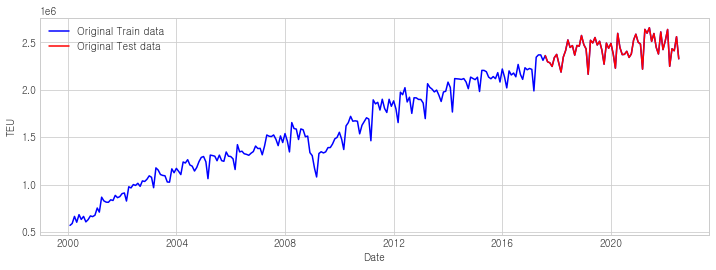

In [9]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Original Train data')
plt.plot(test_data, 'red', label='Original Test data')
plt.legend()

### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

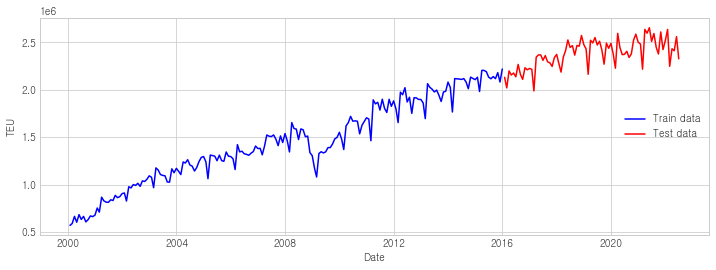

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend(loc=5)

In [17]:
len(train),len(test)

(192, 78)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 12   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((163, 18, 10), (163, 12, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_test= X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_test= Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((49, 18, 10), (49, 12, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(Conv1D(filters=48, kernel_size=2,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),padding='causal',name='extractor'))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(Flatten())
model.add(RepeatVector(12)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(66, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
16/16 [==============================] - 7s 289ms/step - loss: 0.3938 - mae: 0.5385 - val_loss: 0.5492 - val_mae: 0.6972
Epoch 2/200
16/16 [==============================] - 0s 17ms/step - loss: 0.2493 - mae: 0.4142 - val_loss: 0.3433 - val_mae: 0.5114
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.1539 - mae: 0.3121 - val_loss: 0.2843 - val_mae: 0.4698
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.1199 - mae: 0.2796 - val_loss: 0.3097 - val_mae: 0.5158
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0881 - mae: 0.2398 - val_loss: 0.2695 - val_mae: 0.4632
Epoch 6/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0819 - mae: 0.2293 - val_loss: 0.2070 - val_mae: 0.4200
Epoch 7/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0686 - mae: 0.2078 - val_loss: 0.2107 - val_mae: 0.4135
Epoch 8/200
16/16 [==============================] - 0s 18ms/step - loss: 0

In [28]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

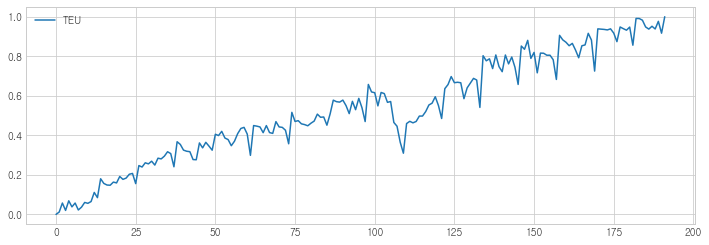

In [29]:
label_train.plot()

<AxesSubplot:>

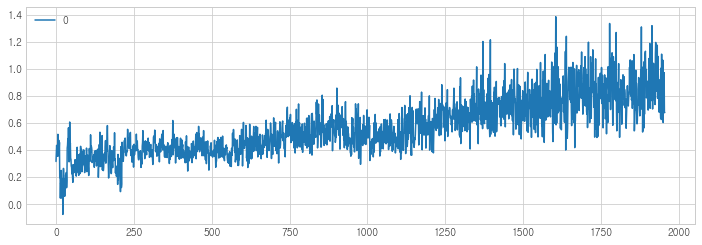

In [30]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

#### Most Probable Explanation

### 1. 2017.07 ~ 2018.06

In [31]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [32]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [33]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

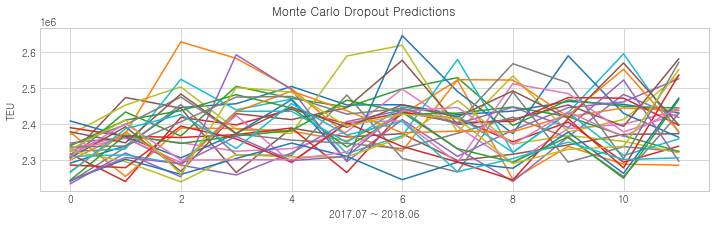

In [34]:
rcParams['figure.figsize'] = 12, 3
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2018.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [35]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [36]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [37]:
np.mean(df.std()/df.mean())

0.031062602996826172

In [37]:
#df.to_csv('CNNLSTM1.csv')

In [39]:
rmse = math.sqrt(mean_squared_error(trend[0:12].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:12].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:12].reset_index()['TEU_Trend'])*100) )

RMSE: 52186.92140907894
MAPE: 1.9888635449328922


In [39]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[:12]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2291891.0,2377597.0,2305751.75,2317747.0,2347832.0,2311901.0,2332989.25,2240577.75,2370750.5,2324334.25,2409007.0,2300228.5,2339775.0,2390196.5,2234603.75,2306809.0,2327444.25,2342488.5,2325920.0,2310456.5,2243870.75,2268450.0,2244406.5,2286888.75,2242838.0,2378750.75,2311040.25,2336677.0,2329451.5,2266009.25


In [40]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:222]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2018-06-30,2443990,1385,2.926085,2.901474,4.385095,110.3,7980.1,1092.8,137274768,103.55


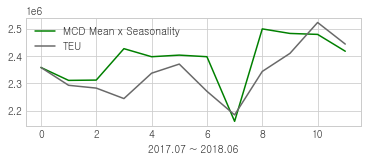

In [48]:
plt.figure(figsize=(6,2))
plt.plot(df.transpose().mean()*seasonal.head(12).reset_index()['Seasonal'],color='green',label='MCD Mean x Seasonality')
plt.plot(test_data.head(12).reset_index()['TEU'],color='dimgrey',label='TEU')
plt.xlabel('2017.07 ~ 2018.06')
plt.legend(loc=2)

Mean RMSE: 104493.74701634364
Mean MAPE: 3.600960292445586


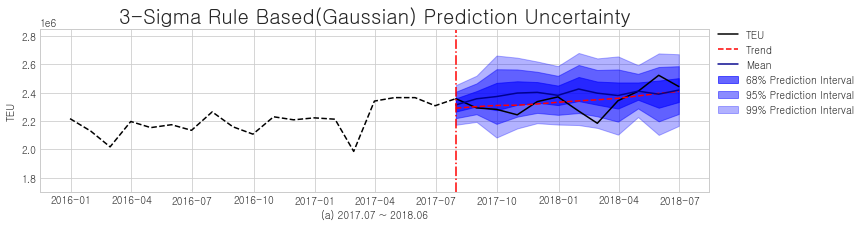

In [41]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().mean())/ test_data.head(12).reset_index()['TEU'])*100) )

In [43]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.9166666666666666
추세 변동에 대한 포함확률: 0.75


Median RMSE: 104898.59136648058
Median MAPE: 3.5578095201479294


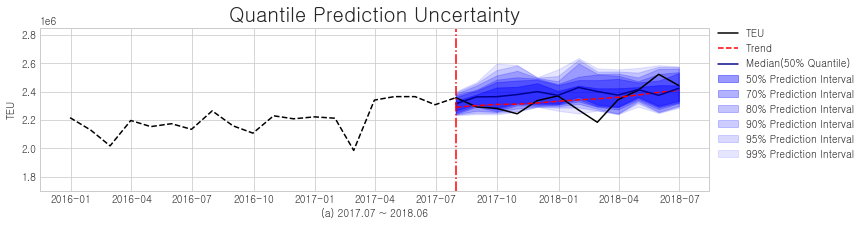

In [44]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.head(12).reset_index()['TEU'])*100) )

In [45]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 0.75


In [46]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 153503.55
Quantile 70% Interval Sharpness 158928.94687499994


RMSE: 119171.50511268587
MAPE: 4.248667908979911


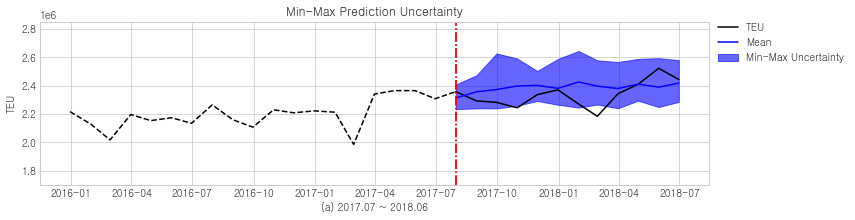

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty')
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')
plt.plot(df2.transpose().mean(),color='blue',label='Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='blue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.head(12).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [48]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334


In [49]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 307007.12
Quantile 95% Interval Sharpness 261910.71458333347
Min Max Interval Sharpness 302814.78


In [50]:
import CRPS.CRPS as pscore

In [51]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(12).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

27642.11527777777
41185.74333333334
45824.392222222225
107654.00305555557
40437.54722222224
16272.480555555556
113007.03916666665
167227.09916666668
26860.10138888889
14005.25138888889
89327.23833333334
24328.42861111111


In [52]:
a = np.array([27642.11527777777,
41185.74333333334,
45824.392222222225,
107654.00305555557,
40437.54722222224,
16272.480555555556,
113007.03916666665,
167227.09916666668,
26860.10138888889,
14005.25138888889,
89327.23833333334,
24328.42861111111])

In [53]:
np.mean(a)

59480.95331018519

In [38]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2387895.0

In [44]:
test_data.head(12).mean()

2338658.5833333335

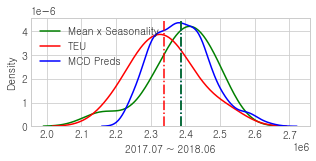

In [41]:
plt.figure(figsize=(5,2))
sns.distplot(df.transpose().mean()*seasonal.head(12).reset_index()['Seasonal'],hist=False,color='green',label='Mean x Seasonality')
#sns.distplot(test_data.head(12),hist=False,color='red',label='TEU')
sns.distplot(test_data.head(12),color='red',label='TEU',hist=False)
sns.distplot(df,hist=False,color='blue',label='MCD Preds')
plt.axvline(2387895.0,color='blue',linestyle='dashdot')
plt.axvline(2387436.5239303163,color='green',linestyle='dashdot')
plt.axvline(test_data.head(12).mean(),color='red',linestyle='dashdot')
plt.xlabel('2017.07 ~ 2018.06')
plt.legend()

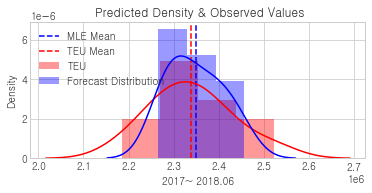

In [37]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(12).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017~ 2018.06')
plt.legend(loc=2)

In [40]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(12).reset_index()['TEU'].mean(), scale=test_data.head(12).reset_index()['TEU'].std() ) )
LL

4640.257732096623

In [43]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5370.852586331721

In [47]:
LL = -np.sum( stats.norm.logpdf(test_data.head(12).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

201.52411147033638

In [48]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [49]:
for i in range(0,30):
    print(KL(df[i],test_data.head(12).reset_index()['TEU']))

1141296.0906118061
247000.28465536563
1315454.718344441
435724.4476322961
211730.53401601157
287934.96652356617
458271.45448877465
126823.65979209224
1542593.3834437267
1078980.4235424337
1118574.1979425617
1452320.3485271344
857713.6071525684
699139.7315507195
716303.0266497589
1060700.8077386783
574860.6077582655
440771.46670404566
21281.267760807576
410194.8032068238
337948.6356205089
752919.5446559754
293720.23979155964
90451.38363117818
283848.66858899663
1149632.8572301061
375692.0291711587
1265579.330013017
729082.7127168726
148405.97549646875


In [62]:
a = np.array([1141296.0906118061,
247000.28465536563,
1315454.718344441,
435724.4476322961,
211730.53401601157,
287934.96652356617,
458271.45448877465,
126823.65979209224,
1542593.3834437267,
1078980.4235424337,
1118574.1979425617,
1452320.3485271344,
857713.6071525684,
699139.7315507195,
716303.0266497589,
1060700.8077386783,
574860.6077582655,
440771.46670404566,
21281.267760807576,
410194.8032068238,
337948.6356205089,
752919.5446559754,
293720.23979155964,
90451.38363117818,
283848.66858899663,
1149632.8572301061,
375692.0291711587,
1265579.330013017,
729082.7127168726,
148405.97549646875])

In [63]:
np.mean(a)

654165.0401652572

In [43]:
attention = pd.read_csv('Attention.csv')
lstm = pd.read_csv('LSTM.csv')
tcn = pd.read_csv('TCN.csv')

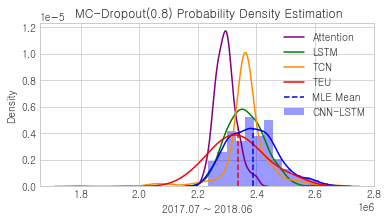

In [54]:
plt.figure(figsize=(6,3))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.head(12).mean(), ymax=0.35, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.35, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2017.07 ~ 2018.06')
plt.legend()

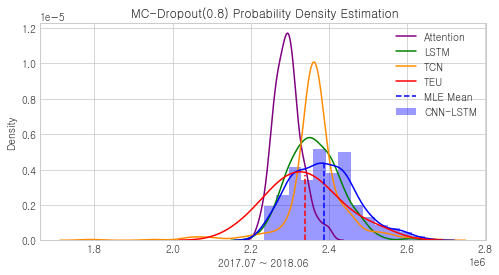

In [51]:
plt.figure(figsize=(8,4))
plt.title(' MC-Dropout(0.8) Probability Density Estimation')
plt.axvline(x=test_data.head(12).mean(), ymax=0.3, color='red',linestyle='dashed')
sns.distplot(attention,color='purple',label='Attention',hist=False)
sns.distplot(lstm,color='green',label='LSTM',hist=False)
sns.distplot(tcn,color='darkorange',label='TCN',hist=False)
sns.distplot(df.transpose(),color='blue',label='CNN-LSTM',hist=True)
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=False)
plt.axvline(x=weight, ymax=0.35, color='blue',linestyle='dashed',label='MLE Mean')
plt.xlabel('2017.07 ~ 2018.06')
plt.legend()

In [66]:
for i in range(0,30):
    print(np.linalg.norm(df[i]-test_data.head(12).reset_index()['TEU']))

RMSE: 77120.00877126641
MAPE: 2.466045830301276
RMSE: 100323.62113918719
MAPE: 3.57794236659841
RMSE: 104129.4710367619
MAPE: 3.253882845070525
RMSE: 102828.2154132713
MAPE: 3.644693289920457
RMSE: 106269.51276412723
MAPE: 3.7486062007523437


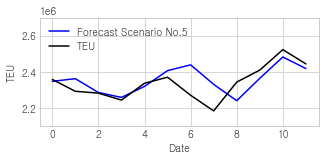

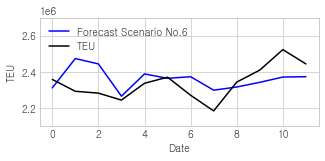

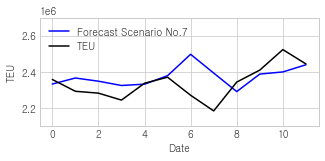

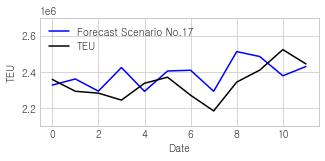

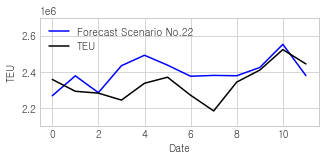

In [56]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)
#plt.title('2017.07 ~ 2018.06')
plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[4]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[4])/ test_data.head(12).reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[5],label='Forecast Scenario No.6',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[5]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[5])/ test_data.head(12).reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[6],label='Forecast Scenario No.7',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[6]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[6])/ test_data.head(12).reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[16]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[16])/ test_data.head(12).reset_index()['TEU'])*100) )

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.7e6)

plt.plot(df[21],label='Forecast Scenario No.22',color='blue')
plt.plot(test_data.head(12).reset_index()['TEU'],label='TEU',color='black')
plt.legend()

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df[21]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df[21])/ test_data.head(12).reset_index()['TEU'])*100) )

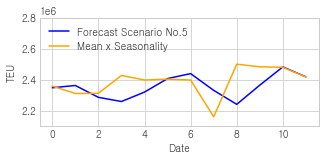

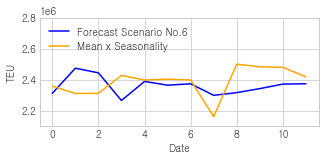

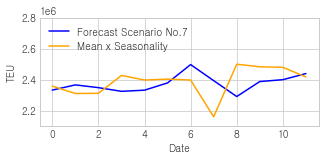

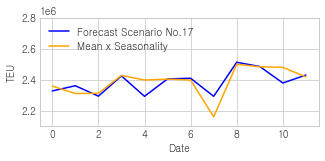

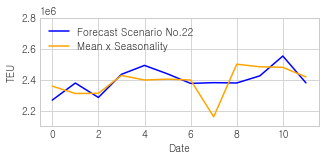

In [44]:
plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
#plt.title('2021.07 ~ 2022.06')
plt.plot(df[4],label='Forecast Scenario No.5',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[5],label='Forecast Scenario No.6',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[6],label='Forecast Scenario No.7',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[16],label='Forecast Scenario No.17',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

plt.figure(figsize=(5,2))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.ylim(2.1e6,2.8e6)
plt.plot(df[21],label='Forecast Scenario No.22',color='blue')
plt.plot(df.transpose().mean()*seasonal['Seasonal'].reset_index()['Seasonal'],color='orange',label='Mean x Seasonality')
plt.legend(loc=2)

### 2022.07 ~ 2023.06 예측 (Out of Dist )

In [52]:
X_test_6 = np.array(feature_test.tail(18)).reshape((1, 18, 10)) 

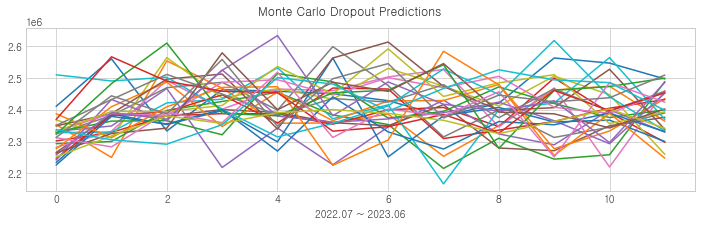

In [53]:
model_MC=  model
prediction = [model_MC.predict(X_test_6) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 12, 3
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2022.07 ~ 2023.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [54]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [55]:
np.mean(df.std()/df.mean())

0.03247656300663948

In [56]:
df2 = pd.read_csv('datetime.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-31,2411073.0,2353348.25,2293342.25,2301836.5,2332445.75,2265637.75,2281557.5,2324300.75,2368113.25,2327754.75,2233720.5,2276749.0,2329793.5,2246044.25,2241766.0,2349338.0,2332440.75,2350588.0,2332534.75,2510528.0,2225981.5,2387563.25,2323095.5,2369731.75,2257803.0,2263521.0,2311928.5,2313049.25,2251736.5,2337301.25


In [57]:
df3 = pd.read_csv('datetime.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.tail(1)

,Time
Date,
2023-06-30,1


In [58]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.tail()

(271, 1)


,TEU
Date,
2022-03-31,2429940
2022-04-30,2409140
2022-05-31,2557448
2022-06-30,2324505
2022-07-31,2324505


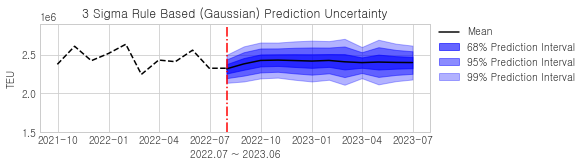

In [99]:
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('3 Sigma Rule Based (Gaussian) Prediction Uncertainty')
plt.ylim(1.5e6,2.9e6)
plt.plot(data['TEU'].iloc[260:271], 'black',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='black',alpha=10.0)
plt.axvline(x='2022-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")


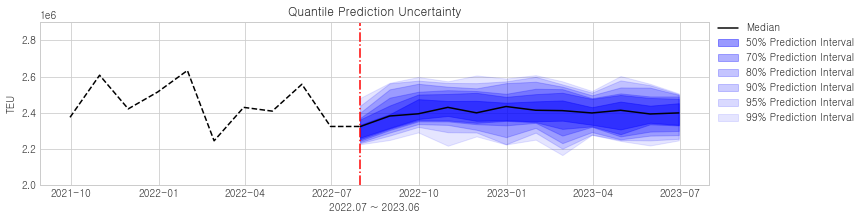

In [62]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty')
plt.ylim(2.0e6,2.9e6)
plt.plot(data['TEU'].iloc[260:271], 'black',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median',color='black',alpha=10.0)
plt.axvline(x='2022-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

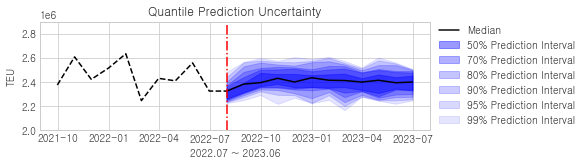

In [97]:
plt.figure(figsize=(7,2))
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=12)
plt.ylim(2.0e6,2.9e6)
plt.plot(data['TEU'].iloc[260:271], 'black',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median',color='black',alpha=10.0)
plt.axvline(x='2022-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [ ]:
#0,1,9,12,13

In [190]:
pd.concat([df[0],df[1],df[9],df[12],df[13]],axis=1).to_csv('1번.csv')

In [191]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,1,2,10,13,14
Date,,,,,
2022-07-31,2411073.0,2353348.2,2327754.8,2329793.5,2246044.2
2022-08-31,2560922.8,2249966.8,2330149.2,2364408.5,2382587.8
2022-09-30,2333511.8,2554530.8,2421787.2,2365891.5,2394256.8
2022-10-31,2463645.8,2468265.0,2433515.5,2321374.2,2447254.8
2022-11-30,2458661.5,2357726.5,2532897.8,2514554.0,2358547.2


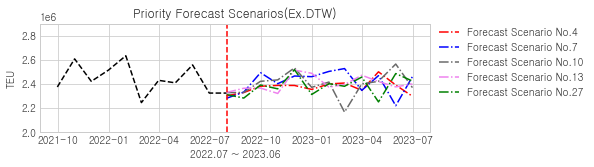

In [96]:
plt.figure(figsize=(7,2))
plt.rcParams.update({'font.size': 10})
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('Priority Forecast Scenarios(Ex.DTW)')
plt.ylim(2.0e6,2.9e6)
plt.plot(data['TEU'].iloc[260:271], 'black',linestyle='dashed')
#plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='black',alpha=10.0)

plt.plot(df3['4'],color='red',label='Forecast Scenario No.4',linestyle='dashdot')
plt.plot(df3['7'],color='blue',label='Forecast Scenario No.7',linestyle='dashdot')
plt.plot(df3['10'],color='dimgrey',label='Forecast Scenario No.10',linestyle='dashdot')
plt.plot(df3['13'],color='violet',label='Forecast Scenario No.13',linestyle='dashdot')
plt.plot(df3['27'],color='green',label='Forecast Scenario No.27',linestyle='dashdot')
#plt.plot(df4)
plt.axvline(x='2022-07-31', color='red',linestyle='dashed')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [76]:
df4 = pd.read_csv('TEU2.csv')
df4['Date'] = pd.to_datetime(df4['Date'])
df4 = df4.set_index('Date')

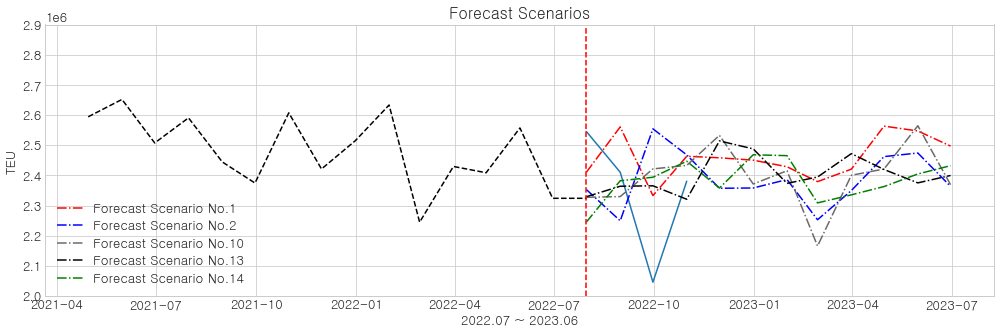

In [208]:
plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 13})
plt.grid(True)
plt.xlabel('2022.07 ~ 2023.06')
plt.ylabel('TEU')
plt.title('Forecast Scenarios')
plt.ylim(2.0e6,2.9e6)
plt.plot(df4)
plt.plot(data['TEU'].iloc[255:271], 'black',linestyle='dashed')
#plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='black',alpha=10.0)

plt.plot(df3['1'],color='red',label='Forecast Scenario No.4',linestyle='dashdot')
plt.plot(df3['2'],color='blue',label='Forecast Scenario No.2',linestyle='dashdot')
plt.plot(df3['10'],color='dimgrey',label='Forecast Scenario No.10',linestyle='dashdot')
plt.plot(df3['13'],color='black',label='Forecast Scenario No.13',linestyle='dashdot')
plt.plot(df3['27'],color='green',label='Forecast Scenario No.14',linestyle='dashdot')
plt.axvline(x='2022-07-31', color='red',linestyle='dashed')
plt.legend(loc=3)

In [65]:
from dtaidistance import dtw

In [66]:
scenario = []

for i in range(0,30):
    a = dtw.distance(df[i], df.transpose().mean()*seasonal['Seasonal'].head(12).reset_index()['Seasonal'])
    scenario.append(a)

In [72]:
pd.concat([df[3],df[6],df[9],df[12],df[26]],axis=1).to_csv('1번.csv')

In [74]:
df3 = pd.read_csv('1번.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.set_index('Date')
df3.head()

,4,7,10,13,27
Date,,,,,
2022-07-31,2301836.5,2281557.5,2327754.8,2329793.5,2311928.5
2022-08-31,2328879.8,2332531.5,2330149.2,2364408.5,2283205.2
2022-09-30,2381022.2,2493176.0,2421787.2,2365891.5,2391387.5
2022-10-31,2387980.5,2401954.8,2433515.5,2321374.2,2359421.0
2022-11-30,2387460.2,2465703.2,2532897.8,2514554.0,2518683.0
